<a href="https://colab.research.google.com/github/xTavi/BlackBoxAttack/blob/master/BlackBoxAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
from matplotlib import pyplot
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')
import torch.onnx
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
# import utils
import math
import random
import pdb

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# class containing parameters for CNN optimizer  
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 10#10
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = False

args = Args()
use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [3]:
# code to download MNIST datasets for first method
# loaders for train and test data, respectively
# the data will be in pytorch tensor format

train_loader = torch.utils.data.DataLoader(
    dset.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    dset.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=True,drop_last=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
# change folder to keep track later on
# note - don't change before downloading the MINST data
os.chdir("/content/gdrive/My Drive/")
# data is saved in the main directory in google drive

In [6]:
# arhitecture for CNN
# will use those same parameters in the following cells
# serves as a starting point for fully connected CNN
number_of_filters_1 = 20
number_of_filters_2 = 50
nn1 = 500
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, number_of_filters_1, 5, 1)
        self.conv2 = nn.Conv2d(number_of_filters_1, number_of_filters_2, 5, 1)
        self.fc1 = nn.Linear(4*4*number_of_filters_2, nn1)
        # 10 classes, one for each digit
        self.fc2 = nn.Linear(nn1, 10)

    def forward(self, x):
        # activation functions
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*number_of_filters_2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# define a function for training and testing, respectively
# similar to what we have done in the laboratory
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    # use batches
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # print loss at every step of the way
        if batch_idx % args.log_interval == 0:
            print('Train data performance for epoch {}:  for {:.0f}% of the data we have loss: {:.6f}'.format(epoch, 100. * batch_idx / len(train_loader), loss.item()))
            
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    # for accuracy we will
    # keep track of how many correct items classified as a percentage of total
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True) 
            # increment correctly classified items
            correct += pred.eq(target.view_as(pred)).sum().item()

    # divide by the number of examples to get average loss
    test_loss /= len(test_loader.dataset)
    # print average loss and accuracy on test data
    print('Computing accuracy on the test data: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [ ]:
# # create and train, test our CNN
# model = CNN().to(device)

# optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

# for epoch in range(1, args.epochs + 1):
#     train(args, model, device, train_loader, optimizer, epoch)
#     test(args, model, device, test_loader)

# # we save the model to save parameters for later
# torch.save(model.state_dict(),"conv_net.pt")

Train data performance for epoch 1:  for 0% of the data we have loss: 2.301512
Train data performance for epoch 1:  for 17% of the data we have loss: 0.420959
Train data performance for epoch 1:  for 33% of the data we have loss: 0.221842
Train data performance for epoch 1:  for 50% of the data we have loss: 0.131827
Train data performance for epoch 1:  for 67% of the data we have loss: 0.005959
Train data performance for epoch 1:  for 83% of the data we have loss: 0.043755
Train data performance for epoch 1:  for 100% of the data we have loss: 0.067109
Computing accuracy on the test data: Average loss: 0.0673, Accuracy: 9760/10000 (98%)
Train data performance for epoch 2:  for 0% of the data we have loss: 0.077691
Train data performance for epoch 2:  for 17% of the data we have loss: 0.012059
Train data performance for epoch 2:  for 33% of the data we have loss: 0.017001
Train data performance for epoch 2:  for 50% of the data we have loss: 0.200627
Train data performance for epoch 2:

Epsilons: List of epsilon values to use for the run. It is important to keep 0 in the list because it represents the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is [0,1], no epsilon value should exceed 1.

In [7]:
pretrained_model = "conv_net.pt"
use_cuda=True

In [8]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = CNN().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. 
model.eval()

CUDA Available:  False


CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

# Let's do a black box SimBa attack

In [9]:
#Here we add the element we need 

adv = []
number_of_correct = 0
accuracies = []

In [10]:
def get_probs(model, x, y):
    output = model(x)
    probs = torch.nn.Softmax(dim=1)(output)[:, y]
    return torch.diag(probs.data)

# 20-line implementation of (untargeted) SimBA for single image input
def simba_single(model, x, y, num_iters=10000, epsilon=0.2):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs(model, x, y)
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[perm[i]] = epsilon
        left_prob = get_probs(model, (x - diff.view(x.size())).clamp(0, 1), y)
        if left_prob < last_prob:
            x = (x - diff.view(x.size())).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs(model, (x + diff.view(x.size())).clamp(0, 1), y)
            if right_prob < last_prob:
                x = (x + diff.view(x.size())).clamp(0, 1)
                last_prob = right_prob
        # Here I want that if the model missclasify it to stop the procedure
        prediction = model(x).argmax()
        # We save the adversarial examples as a touple formed by initial label, predicted label, adversarial_image and epsioln
        if prediction != y:
          adv.append((y.item(), prediction.item(), x, epsilon))
          break

    return x

We can attack now

In [ ]:
# This function should return the accouracy for a given epsilon
def adversarial_attack(epsilon):
  for batch_idx, (data, target) in enumerate(test_loader):
          data, target = data.to(device), target.to(device)
          initial_predictions = model(data)
          initial_predictions = initial_predictions.argmax(dim=1, keepdim=True)
          initial_correctness = 0
          initial_correctness += initial_predictions.eq(target.view_as(initial_predictions)).sum().item()
          
          print(f'Initial accuracy for batch {batch_idx}/{ math.floor(len(test_loader.dataset)/len(data)) } was ', 100.  * initial_correctness / len(target), "%")

          bigger_result = torch.zeros(1,1,28,28)
          for x, y in zip(data,target):
            x = x.unsqueeze(dim=0)
            result = simba_single(model, x, y, 784, epsilon)
            result.unsqueeze(dim=0)
            bigger_result = torch.cat((bigger_result, result))

          final_result = bigger_result[1:]
          final_predictions = model(final_result).argmax(dim=1, keepdim=True)
          final_corectness = 0
          final_corectness += final_predictions.eq(target.view_as(final_predictions)).sum().item()
          # number_of_correct += final_corectness
          accouracy  = 100.  * final_corectness / len(target)
          print(f'Final accuracy for batch {batch_idx}/{math.floor(len(test_loader.dataset)/len(data))  } was ', accouracy ,"%")
          
          return accouracy


In [ ]:
epsilons = [0, .05, .1, .15, .2]

for eps in epsilons:
    acc = adversarial_attack(eps)
    accuracies.append(acc)

In [ ]:
tensor_accuracies = torch.tensor(accuracies)/100

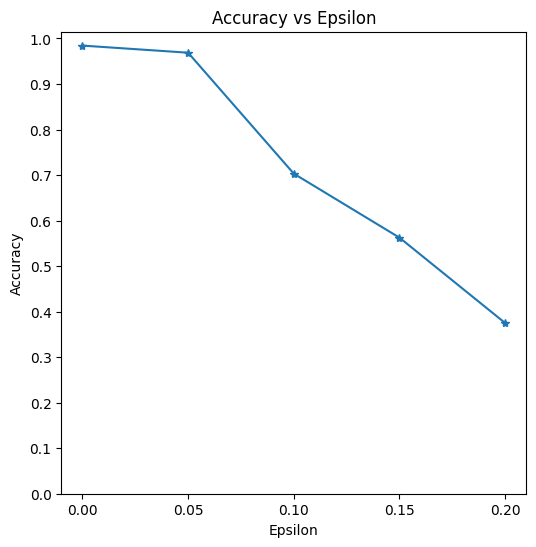

In [ ]:
plt.figure(figsize=(6,6))
# print(accuracies)
plt.plot(epsilons, tensor_accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .25, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# We want to create an len(epsilons)*5 matrix for printing

matrix = []

In [ ]:
for epsilon in epsilons:
  i = 0;
  for item_adv in adv:
    if item_adv[3] == epsilon and i<5:
      matrix.append(item_adv)
      i+=1
      print(f"am gaist unu pentru eps {epsilon}")

print(len(matrix))


am gaist unu pentru eps 0
am gaist unu pentru eps 0.05
am gaist unu pentru eps 0.05
am gaist unu pentru eps 0.1
am gaist unu pentru eps 0.1
am gaist unu pentru eps 0.1
am gaist unu pentru eps 0.1
am gaist unu pentru eps 0.1
am gaist unu pentru eps 0.15
am gaist unu pentru eps 0.15
am gaist unu pentru eps 0.15
am gaist unu pentru eps 0.15
am gaist unu pentru eps 0.15
am gaist unu pentru eps 0.2
am gaist unu pentru eps 0.2
am gaist unu pentru eps 0.2
am gaist unu pentru eps 0.2
am gaist unu pentru eps 0.2
18


In [ ]:
matrix[0]

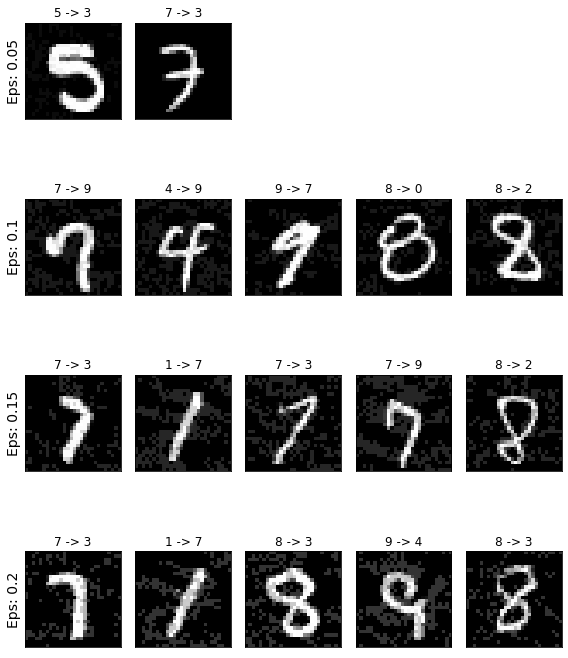

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
poz =0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)-1):
    for special in range(2):
      if cnt > 3:
        continue
      cnt += 1
      plt.subplot(4, 5, cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if cnt == 1:
        plt.ylabel("Eps: {}".format(epsilons[i+1]), fontsize=14)
      orig,adv,ex,_ = matrix[poz]
      poz += 1
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex[0][0], cmap="gray")
      if cnt == 2:
        cnt += 3
    for j in range(5):
        if cnt < 5 or cnt >= 20:
          continue
        cnt += 1
        plt.subplot(4, 5, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j%5 == 0:
            plt.ylabel("Eps: {}".format(epsilons[i+2]), fontsize=14)
        orig,adv,ex,_ = matrix[poz]
        poz += 1
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex[0][0], cmap="gray")
plt.tight_layout()
plt.show() 

# Here we will add the second cnn called LeNet5 - 1990

In [11]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 10

IMG_SIZE = 32
N_CLASSES = 10

In [14]:
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [ ]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [15]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            #print(X.size())
            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [ ]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [16]:
# define transforms
transforms1 = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms1,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms1)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [ ]:
trans = transforms.ToPILImage()

In [ ]:
trans1 = transforms.ToTensor()
plt.imshow(trans(trans1(img)))

In [ ]:
trans(b)

In [ ]:
type(trans(b))

c = transforms1(trans(b))


In [ ]:
c.size()

torch.Size([1, 32, 32])

In [17]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [18]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

11:04:09 --- Epoch: 0	Train loss: 0.2300	Valid loss: 0.0898	Train accuracy: 97.33	Valid accuracy: 97.27
11:04:53 --- Epoch: 1	Train loss: 0.0789	Valid loss: 0.0808	Train accuracy: 97.85	Valid accuracy: 97.59
11:05:37 --- Epoch: 2	Train loss: 0.0555	Valid loss: 0.0553	Train accuracy: 98.60	Valid accuracy: 98.28
11:06:22 --- Epoch: 3	Train loss: 0.0444	Valid loss: 0.0491	Train accuracy: 98.93	Valid accuracy: 98.47
11:07:06 --- Epoch: 4	Train loss: 0.0348	Valid loss: 0.0465	Train accuracy: 99.21	Valid accuracy: 98.54
11:07:51 --- Epoch: 5	Train loss: 0.0297	Valid loss: 0.0435	Train accuracy: 99.25	Valid accuracy: 98.70
11:08:35 --- Epoch: 6	Train loss: 0.0260	Valid loss: 0.0434	Train accuracy: 99.50	Valid accuracy: 98.74
11:09:19 --- Epoch: 7	Train loss: 0.0213	Valid loss: 0.0478	Train accuracy: 99.39	Valid accuracy: 98.55
11:10:04 --- Epoch: 8	Train loss: 0.0198	Valid loss: 0.0423	Train accuracy: 99.59	Valid accuracy: 98.78
11:10:48 --- Epoch: 9	Train loss: 0.0170	Valid loss: 0.0481	Trai

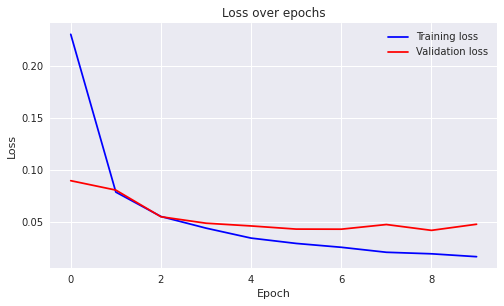

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

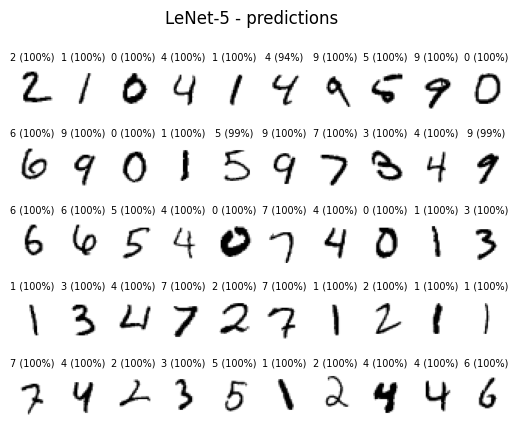

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [ ]:
# # we save the model to save parameters for later
# torch.save(model.state_dict(),"LeNet5.pt")

# use_cuda = True 

In [19]:
pretrained_model = "LeNet5.pt"

# Here we load the model 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model1 = LeNet5(10).to(device)

# Load the pretrained model
model1.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. 
model1.eval()

CUDA Available:  False


LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
# We save the adversarial examples as a touple formed by initial label, predicted label, adversarial_image and epsioln
adversarial_image = adv[0][2]



a = adv[0][2].squeeze(dim=0)
b = a.squeeze(dim=0)
plt.imshow(b,  cmap='gray_r')

# b.reshape(32,32)
print(b.size())

model(adv[0][2]).argmax()
model1(b)

In [ ]:
c.size()

d = c.unsqueeze(dim=0)
print(d.size())

In [ ]:
model1.eval()

model1(d)[1].argmax()

In [20]:
def transform_image(image):
  # we get a [1, 1, 28, 28] tensor and we return a [1, 1, 32, 32]
  new_image = image.squeeze(dim=0).squeeze(dim=0)
  trans = transforms.ToPILImage()
  new_image = transforms1(trans(new_image))
  new_image = new_image.unsqueeze(dim=0)
  return new_image

3
torch.Size([1, 1, 32, 32])


tensor(5)

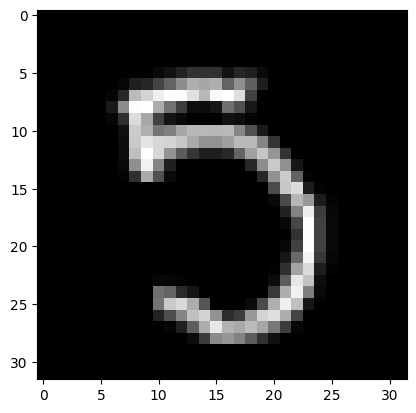

In [ ]:
image = adv[1][2]

print(adv[1][1])
print(transform_image(image).size())

image2 = transform_image(image)

plt.imshow(image2.squeeze(dim=0).squeeze(dim=0), cmap='gray')

model1(image2)[1].argmax()

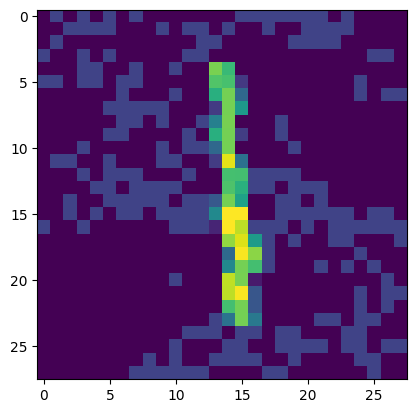

In [ ]:
plt.imshow(adv[len(adv)-1][2][0][0])

# Here is the last and the 3rd network - ResNet18

In [21]:


import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline




In [22]:
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_csv_path = 'train.csv'
test_csv_path = 'test.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# have a glimpse of train dataframe structure
n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))
print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))
print(train_df.head())

# have a glimpse of test dataframe structure
n_test = len(test_df)
n_pixels = len(test_df.columns)
print('Number of test samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))
print(test_df.head())

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10
   label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0      1       0       0       0  ...         0         0         0         0
1      0       0       0       0  ...         0         0         0         0
2      1       0       0       0  ...         0         0         0         0
3      4       0       0       0  ...         0         0         0         0
4      0       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]
Number of test samples: 28000
Number of test pixels: 784
   pixel0  pixel1  pixel2  pixel3  ...  pixel780  pixel781  pixel782  pixel783
0       0       0       0       0  ...         0         0         0         0
1       0       0       0       0  ...         0         0         0         0
2       0       0       0       0  ...         0         0         0         0
3       0       0       0       0  ...         0

4, 6, 6, 4, 3, 6, 6, 1


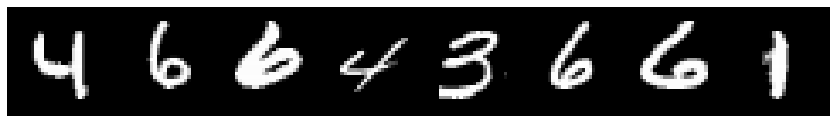

In [ ]:
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((train_df.iloc[random_sel, 1:].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

In [23]:
class MNISTDataset(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, dataframe, 
                 transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        df = dataframe
        # for MNIST dataset n_pixels should be 784
        self.n_pixels = 784
        
        if len(df.columns) == self.n_pixels:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [ ]:
RandAffine = transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2))

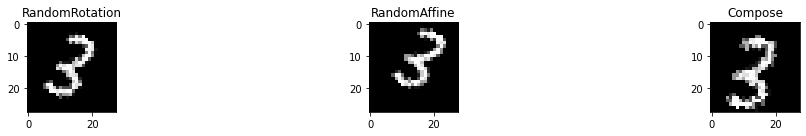

In [ ]:
rotate = transforms.RandomRotation(degrees=45)
shift = RandAffine
composed = transforms.Compose([rotate,
                               shift])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(train_df.iloc[65,1:].values.reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

plt.show()

In [ ]:
batch_size = 64

train_transforms = transforms.Compose(
    [transforms.ToPILImage(),
     RandAffine,
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))])

val_test_transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))])

def get_dataset(dataframe, dataset=MNISTDataset,
                transform=transforms.Compose([transforms.ToPILImage(),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(0.5,), std=(0.5,))])):
    return dataset(dataframe, transform=transform)

In [24]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MNISTResNet(ResNet):
    def __init__(self):
        super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18
        # super(MNISTResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=10) # Based on ResNet34
        # super(MNISTResNet, self).__init__(Bottleneck, [3, 4, 6, 3], num_classes=10) # Based on ResNet50
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)

model = MNISTResNet()
print(model)

MNISTResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # if GPU available, move data and target to GPU
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # compute output and loss
        output = model(data)
        loss = criterion(output, target)
        
        # TODO:
        # 1. add batch metric (acc1, acc5)
        # 2. add average metric top1=sum(acc1)/batch_idx, top5 = sum(acc5)/batch_idx
        
        # backward and update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data.item()))

In [ ]:
def validate(val_loader, model, criterion):
    model.eval()
    loss = 0
    correct = 0
    
    for _, (data, target) in enumerate(val_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += criterion(output, target).data.item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(val_loader.dataset)
        
    print('\nOn Val set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(val_loader.dataset),
        100.0 * float(correct) / len(val_loader.dataset)))

In [25]:
# example config, use the comments to get higher accuracy
total_epoches = 5 # 50
step_size = 10     # 10
base_lr = 0.01    # 0.01

optimizer = optim.Adam(model.parameters(), lr=base_lr)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
def split_dataframe(dataframe=None, fraction=0.9, rand_seed=1):
    df_1 = dataframe.sample(frac=fraction, random_state=rand_seed)
    df_2 = dataframe.drop(df_1.index)
    return df_1, df_2

for epoch in range(total_epoches):
    print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))

    train_df_new, val_df = split_dataframe(dataframe=train_df, fraction=0.9, rand_seed=epoch)
    
    train_dataset = get_dataset(train_df_new, transform=train_transforms)
    val_dataset = get_dataset(val_df, transform=val_test_transforms)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size, shuffle=False)

    train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)
    validate(val_loader=val_loader, model=model, criterion=criterion)
    exp_lr_scheduler.step()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



Train Epoch 0: lr = 0.01
Train Epoch: 0 [6400/37800 (17%)]	Loss: 0.329609
Train Epoch: 0 [12800/37800 (34%)]	Loss: 0.417190
Train Epoch: 0 [19200/37800 (51%)]	Loss: 0.254208
Train Epoch: 0 [25600/37800 (68%)]	Loss: 0.253631
Train Epoch: 0 [32000/37800 (85%)]	Loss: 0.282886

On Val set Average loss: 0.0019, Accuracy: 4031/4200 (95.976%)


Train Epoch 1: lr = 0.01
Train Epoch: 1 [6400/37800 (17%)]	Loss: 0.215688
Train Epoch: 1 [12800/37800 (34%)]	Loss: 0.147227
Train Epoch: 1 [19200/37800 (51%)]	Loss: 0.158586
Train Epoch: 1 [25600/37800 (68%)]	Loss: 0.023017
Train Epoch: 1 [32000/37800 (85%)]	Loss: 0.105355

On Val set Average loss: 0.0014, Accuracy: 4075/4200 (97.024%)


Train Epoch 2: lr = 0.01
Train Epoch: 2 [6400/37800 (17%)]	Loss: 0.147845
Train Epoch: 2 [12800/37800 (34%)]	Loss: 0.074943
Train Epoch: 2 [19200/37800 (51%)]	Loss: 0.146451
Train Epoch: 2 [25600/37800 (68%)]	Loss: 0.171136
Train Epoch: 2 [32000/37800 (85%)]	Loss: 0.216073

On Val set Average loss: 0.0010, Accuracy: 4

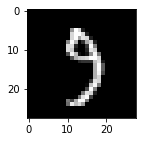

In [ ]:
print_image(adv[0][2])

In [66]:
def print_image(image):
  plt.imshow(image.squeeze(dim=0).squeeze(dim=0), cmap='gray')

In [ ]:
# # we save the model to save parameters for later
# torch.save(model.state_dict(),"ResNet.pt")

# use_cuda = True 

In [26]:
pretrained_model = "ResNet.pt"

# Here we load the model 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model1 = MNISTResNet().to(device)

# Load the pretrained model
model1.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. 
model1.eval()

CUDA Available:  False


MNISTResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [27]:
def choose(a, b, c):
  # print(a.squeeze(dim=0).size(),b.size(),c.size())
  none = (a.squeeze(dim=0) + b.squeeze(dim=0) + c.squeeze(dim=0))
  # print("dsd")
  # print(none)
  return none

In [ ]:
  none = torch.zeros(10)
  none[1] = 4
  none[4] = 4
print(none.argmax())

tensor(4)


In [28]:
def ensamble_prediction(image):
  # First we load the models
  pretrained_model1 = "conv_net.pt"
  pretrained_model2 = "LeNet5.pt"
  pretrained_model3 = "ResNet.pt"
  # Here we load the model 
  
  device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

  # Initialize the network
  model1 = CNN().to(device)
  model2 = LeNet5(10).to(device)
  model3 = MNISTResNet().to(device)

  # Load the pretrained model
  model1.load_state_dict(torch.load(pretrained_model1, map_location='cpu'))
  model2.load_state_dict(torch.load(pretrained_model2, map_location='cpu'))
  model3.load_state_dict(torch.load(pretrained_model3, map_location='cpu'))
  # Set the model in evaluation mode. 
  model1.eval()
  model2.eval()
  model3.eval()

  # We save the adversarial examples as a touple formed by initial label, predicted label, adversarial_image and epsioln
  #print_image(image[2])
  #print('Labelul initial este:', image[0] )

  # first_prediction = model1(image[2]).argmax()
  # second_prediction = model2(transform_image(image[2]))[1].argmax()
  # third_prediction = model3(image[2]).argmax()

  first_prediction = model1(image)
  second_prediction = model2(transform_image(image))[1]
  third_prediction = model3(image)

  predicted_label = choose(first_prediction, second_prediction, third_prediction)

  print('Labelul prezis este: ', predicted_label.argmax())
  return predicted_label

Labelul initial este: 0
tensor(8) tensor(0) tensor(1)
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0.])


tensor(8)

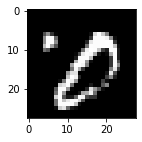

In [ ]:
correct_predictions = 0
for image in adv:
  if image[0] == ensamble_prediction(image).item():
    correct_predictions+=1

print(len(adv))
print(correct_predictions)


In [ ]:
accuracy = correct_predictions * 100 / len(adv)
print(accuracy)

34.5679012345679


In [ ]:
fixed_data[0].size()

In [ ]:
for batch_idx, (data, target) in enumerate(test_loaderr):
        print(data.size())
        output = model(data)
        break

In [ ]:
for (data,lisdst) in test_loaderr:
  print(ensamble_prediction(data[3].unsqueeze(dim=0)))
  print(lisdst[3])
  break

torch.Size([1, 28, 28])
None


# Aici o sa pun finalul proiectului 

In [29]:
train_loaderr = torch.utils.data.DataLoader(
    dset.MNIST('/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loaderr = torch.utils.data.DataLoader(
    dset.MNIST('/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=True,drop_last=True, **kwargs)

Extracting /MNIST/raw/train-images-idx3-ubyte.gz to /MNIST/raw


Extracting /MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST/raw


Extracting /MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST/raw





Extracting /MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST/raw
Processing...
Done!


In [30]:
bunch_of_digits = torch.zeros(1,1,28,28)
bunch_of_labels = torch.zeros(1)
for batch_idx, (data,label) in enumerate(test_loaderr):
  if batch_idx > 14:
    break
  else:
    bunch_of_digits = torch.cat((bunch_of_digits, data))
    bunch_of_labels = torch.cat((bunch_of_labels, label))

bunch_of_digits = bunch_of_digits[1:]
bunch_of_labels = bunch_of_labels[1:]
  

In [41]:
bunch_of_digits.size()

torch.Size([960, 1, 28, 28])

In [31]:
for i in range(10):
  a = ensamble_prediction(bunch_of_digits[i].unsqueeze(dim=0))


Labelul prezis este:  tensor(3)
Labelul prezis este:  tensor(7)
Labelul prezis este:  tensor(8)
Labelul prezis este:  tensor(6)
Labelul prezis este:  tensor(0)
Labelul prezis este:  tensor(2)
Labelul prezis este:  tensor(6)
Labelul prezis este:  tensor(5)
Labelul prezis este:  tensor(3)
Labelul prezis este:  tensor(6)


In [32]:
adv = []
number_or_tries_model1 = []

In [33]:
def get_probs1(model, x, y):
    output = model(x)
    probs = torch.nn.Softmax(dim=1)(output)[:, y]
    return torch.diag(probs.data)

# 20-line implementation of (untargeted) SimBA for single image input
def simba_single1(model, x, y, num_iters=10000, epsilon=0.2, tries=1):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs1(model, x, y)
    number_of_tries = tries
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[perm[i]] = epsilon
        left_prob = get_probs1(model, (x - diff.view(x.size())).clamp(0, 1), y)
        number_of_tries += 1
        if left_prob < last_prob:
            x = (x - diff.view(x.size())).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs1(model, (x + diff.view(x.size())).clamp(0, 1), y)
            number_of_tries += 1
            if right_prob < last_prob:
                x = (x + diff.view(x.size())).clamp(0, 1)
                last_prob = right_prob
        # Here I want that if the model missclasify it to stop the procedure
        prediction = model(x).argmax()
        # We save the adversarial examples as a touple formed by initial label, predicted label, adversarial_image and epsioln
        if prediction != y:
          adv.append((y.item(), prediction.item(), x, epsilon))
          break

    return x, number_of_tries

In [3]:
 # First we load the models
pretrained_model1 = "conv_net.pt"
pretrained_model2 = "LeNet5.pt"
pretrained_model3 = "ResNet.pt"
# Here we load the model 

device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model1 = CNN().to(device)
model2 = LeNet5(10).to(device)
model3 = MNISTResNet().to(device)

# Load the pretrained model
model1.load_state_dict(torch.load(pretrained_model1, map_location='cpu'))
model2.load_state_dict(torch.load(pretrained_model2, map_location='cpu'))
model3.load_state_dict(torch.load(pretrained_model3, map_location='cpu'))
# Set the model in evaluation mode. 
model1.eval()
model2.eval()
model3.eval()

NameError: ignored

In [ ]:
x, tries = simba_single1(model1, bunch_of_digits[0].unsqueeze(dim=1), torch.Tensor.long(bunch_of_labels[0]), 784, 0.1)

In [ ]:
output = model1(bunch_of_digits[0].unsqueeze(dim=1))

In [ ]:
print(output.argmax())

tensor(6)


In [ ]:
print(torch.nn.Softmax(dim=1)(output)[:,torch.Tensor.long(bunch_of_labels[0])])

tensor([0.9998], grad_fn=<SelectBackward>)


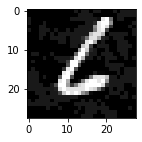

In [ ]:
print_image(x)

In [ ]:
model1(x).argmax()

tensor(2)

In [ ]:
print(tries)

1202


In [ ]:
# Let s calculate how many queries we are doing for model1
queries = []
adversarial = []
for idx, (data,label) in enumerate(zip(bunch_of_digits, bunch_of_labels)):
  if idx % 100 == 0:
    print(idx, "/", len(bunch_of_digits))
  x, tries = simba_single1(model1, data.unsqueeze(dim=1), torch.Tensor.long(label), 784, 0.15)
  print(model1(x).argmax(), label)
  while model1(x).argmax() == label:
     x, tries = simba_single1(model1, x, torch.Tensor.long(label), 784, 0.15, tries)
     if tries > 12000:
       break
  adversarial.append(x)
  queries.append(tries)


In [46]:
len(adversarial)

960

In [47]:
a = torch.Tensor(queries)
print(torch.mean(a))

tensor(5512.2822)


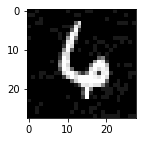

In [ ]:
print_image(adversarial[9])

In [40]:
len(queries)

1294

# This is for the second network

In [52]:
def get_probs2(model, x, y):
    output = model(x)[1]
    probs = torch.nn.Softmax(dim=1)(output)[:, y]
    return torch.diag(probs.data)

# 20-line implementation of (untargeted) SimBA for single image input
def simba_single2(model, x, y, num_iters=10000, epsilon=0.2, tries=1):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs2(model, x, y)
    number_of_tries = tries
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[perm[i]] = epsilon
        left_prob = get_probs2(model, (x - diff.view(x.size())).clamp(0, 1), y)
        number_of_tries += 1
        if left_prob < last_prob:
            x = (x - diff.view(x.size())).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs2(model, (x + diff.view(x.size())).clamp(0, 1), y)
            number_of_tries += 1
            if right_prob < last_prob:
                x = (x + diff.view(x.size())).clamp(0, 1)
                last_prob = right_prob
        # Here I want that if the model missclasify it to stop the procedure
        prediction = model(x)[1].argmax()
        # We save the adversarial examples as a touple formed by initial label, predicted label, adversarial_image and epsioln
        if prediction != y:
          adv.append((y.item(), prediction.item(), x, epsilon))
          break

    return x, number_of_tries

In [51]:
model2(transform_image(bunch_of_digits[0]))[1]

tensor([[5.9161e-09, 5.2630e-08, 6.4167e-08, 9.9999e-01, 1.3593e-09, 7.0293e-06,
         6.0239e-12, 1.1317e-08, 7.5383e-07, 5.3087e-07]],
       grad_fn=<SoftmaxBackward>)

In [ ]:
# Let s calculate how many queries we are doing for model2
queries2 = []
adversarial2 = []
for idx, (data,label) in enumerate(zip(bunch_of_digits, bunch_of_labels)):
  if idx % 100 == 0:
    print(idx, "/", len(bunch_of_digits))
  x, tries = simba_single2(model2, transform_image(data.unsqueeze(dim=1)), torch.Tensor.long(label), 1024, 0.15)
  print(model2(x)[1].argmax(), label)
  while model2(x)[1].argmax() == label:
     x, tries = simba_single2(model2, x, torch.Tensor.long(label), 784, 0.15, tries)
     if tries > 12000:
       break
  adversarial2.append(x)
  queries2.append(tries)

In [57]:
len(adversarial2)

960

In [58]:
len(queries2)

960

In [60]:
b = torch.Tensor(queries2)
print(torch.mean(b))

tensor(2537.1282)


# Let s do the same for model 3

In [ ]:
def get_probs1(model, x, y):
    output = model(x)
    probs = torch.nn.Softmax(dim=1)(output)[:, y]
    return torch.diag(probs.data)

# 20-line implementation of (untargeted) SimBA for single image input
def simba_single1(model, x, y, num_iters=10000, epsilon=0.2, tries=1):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs1(model, x, y)
    number_of_tries = tries
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[perm[i]] = epsilon
        left_prob = get_probs1(model, (x - diff.view(x.size())).clamp(0, 1), y)
        number_of_tries += 1
        if left_prob < last_prob:
            x = (x - diff.view(x.size())).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs1(model, (x + diff.view(x.size())).clamp(0, 1), y)
            number_of_tries += 1
            if right_prob < last_prob:
                x = (x + diff.view(x.size())).clamp(0, 1)
                last_prob = right_prob
        # Here I want that if the model missclasify it to stop the procedure
        prediction = model(x).argmax()
        # We save the adversarial examples as a touple formed by initial label, predicted label, adversarial_image and epsioln
        if prediction != y:
          adv.append((y.item(), prediction.item(), x, epsilon))
          break

    return x, number_of_tries

In [ ]:
# Let s calculate how many queries we are doing for model3
queries3 = []
adversarial3 = []
for idx, (data,label) in enumerate(zip(bunch_of_digits, bunch_of_labels)):
  if idx % 100 == 0:
    print(idx, "/", len(bunch_of_digits))
  x, tries = simba_single1(model3, transform_image(data.unsqueeze(dim=1)), torch.Tensor.long(label), 784, 0.15)
  print(model3(x).argmax(), label)
  while model3(x).argmax() == label:
     x, tries = simba_single1(model3, x, torch.Tensor.long(label), 784, 0.15, tries)
     if tries > 12000:
       break
  adversarial3.append(x)
  queries3.append(tries)

In [94]:
import csv

with open("third.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(queries3)

# For the entire ensamble

In [120]:
def get_probs4(model, x, y):
    output = model(x)
    probs = torch.nn.Softmax(dim=0)(output)[y]
    return torch.diag(probs.data)

# 20-line implementation of (untargeted) SimBA for single image input
def simba_single4(model, x, y, num_iters=10000, epsilon=0.2, tries=1):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs4(model, x, y)
    number_of_tries = tries
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[perm[i]] = epsilon
        left_prob = get_probs4(model, (x - diff.view(x.size())).clamp(0, 1), y)
        number_of_tries += 1
        if left_prob < last_prob:
            x = (x - diff.view(x.size())).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs4(model, (x + diff.view(x.size())).clamp(0, 1), y)
            number_of_tries += 1
            if right_prob < last_prob:
                x = (x + diff.view(x.size())).clamp(0, 1)
                last_prob = right_prob
        # Here I want that if the model missclasify it to stop the procedure
        prediction = model(x).argmax()
        # We save the adversarial examples as a touple formed by initial label, predicted label, adversarial_image and epsioln
        if prediction != y:
          adv.append((y.item(), prediction.item(), x, epsilon))
          break

    return x, number_of_tries

In [121]:
# Let s calculate how many queries we are doing for model3
queries4 = []
adversarial4 = []
for idx, (data,label) in enumerate(zip(bunch_of_digits, bunch_of_labels)):
  if idx % 100 == 0:
    print(idx, "/", len(bunch_of_digits))
  x, tries = simba_single4(ensamble_prediction, data.unsqueeze(dim=1), torch.Tensor.long(label), 784, 0.15)
  print(ensamble_prediction(x).argmax(), label)
  while ensamble_prediction(x).argmax() == label:
     x, tries = simba_single4(ensamble_prediction, x, torch.Tensor.long(label), 784, 0.15, tries)
     if tries > 12000:
       break
  adversarial4.append(x)
  queries4.append(tries)

0 / 960
Labelul prezis este:  tensor(3)


RuntimeError: ignored

In [ ]:
print_image(adversarial3[0])

In [78]:
queries3[7]

359

In [81]:
model3(adversarial3[0])

tensor([[-1.1639, -0.0201, -2.8287,  0.6707, -1.5930,  0.9615, -1.8172, -2.0499,
          0.8685, -0.7435]], grad_fn=<AddmmBackward>)

In [92]:
import csv

with open('first', newline='') as f:
    reader = csv.reader(f)
    dataaa = list(reader)

print(len(dataaa[0]))

960


In [105]:
for idx, (data,label) in enumerate(zip(bunch_of_digits, bunch_of_labels)):
  print(ensamble_prediction(data.unsqueeze(dim=0)))

Labelul prezis este:  tensor(3)
tensor([-35.6044, -32.5661, -37.5511,   2.1517, -45.1567, -17.9615, -40.9323,
        -39.6692, -16.6484, -25.0194], grad_fn=<AddBackward0>)
Labelul prezis este:  tensor(7)
tensor([-27.6426, -17.4321, -20.7313,  -5.3093, -22.6639, -21.3895, -36.5409,
          4.8624, -16.4314, -14.6766], grad_fn=<AddBackward0>)
Labelul prezis este:  tensor(8)
tensor([-34.3344, -33.2318, -30.3215, -14.8095, -36.3805, -27.2375, -32.3148,
        -36.2287,   7.1933, -26.1948], grad_fn=<AddBackward0>)
Labelul prezis este:  tensor(6)
tensor([-20.7594, -22.7379, -30.3052, -26.9088, -17.1700, -21.7347,   0.3903,
        -37.1760, -24.7400, -31.3635], grad_fn=<AddBackward0>)
Labelul prezis este:  tensor(0)
tensor([  6.8719, -25.6556, -13.9451, -29.5850, -29.4054, -28.5903, -20.4722,
        -21.8081, -21.8520, -15.0672], grad_fn=<AddBackward0>)
Labelul prezis este:  tensor(2)
tensor([-26.0826, -13.4166,   1.9069, -22.3190, -24.4004, -26.9466, -31.0154,
        -12.2366, -20.748

KeyboardInterrupt: ignored

In [ ]:
output = model(x)
probs = torch.nn.Softmax(dim=1)(output)[:, y]
return torch.diag(probs.data)

In [2]:
a = model1(bunch_of_digits[0].unsqueeze(dim=0))
probs = torch.nn.Softmax(dim=1)(a)[:, 2]
torch.diag(probs.data)

NameError: ignored

In [113]:
b = ensamble_prediction(bunch_of_digits[0].unsqueeze(dim=0))
print(torch.nn.Softmax(dim=0)(b))

Labelul prezis este:  tensor(3)
tensor([4.0063e-17, 8.3611e-16, 5.7187e-18, 1.0000e+00, 2.8461e-21, 1.8406e-09,
        1.9447e-19, 6.8777e-19, 6.8430e-09, 1.5840e-12],
       grad_fn=<SoftmaxBackward>)


In [1]:
torch.diag(list(2))

NameError: ignored